In [25]:
from utils.prep import *
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from skimage import io, measure, morphology

In [26]:
def get_dab(img):
    # gray macenko
    normalizer = NumpyMacenkoNormalizer()
    normalizer.fit(img)
    Inorm, H, DAB, C2 = normalizer.normalize(img)
    c = C2[1].reshape(img.shape[:-1])
    gray = np.round((c - c.min()) / (c.max() - c.min()) * 255).astype(np.uint8)
    return gray

def white_balance(img, q=99):
    norm_img = (img / np.percentile(img, axis=(0, 1), q=q)).clip(0, 1) * 255
    return np.round(norm_img).astype(np.uint8)

In [27]:
def init_hist(bin_img):
    life_dict = {
    }
    labeled_img = measure.label(bin_img)
    unique_labels = np.unique(labeled_img[labeled_img > 0])
    for label in unique_labels:
        life_dict[int(label)] = {
            "birth": 0,
            "death": None
        }
    if len(unique_labels) > 0:
        max_cur_label = np.max(unique_labels)
    else:
        max_cur_label = 0
    return life_dict, labeled_img, max_cur_label

def update_hist(prev_labeled_img, cur_bin, life_dict, max_cur_label, timestep):
    labeled_img = measure.label(cur_bin)
    ids = np.unique(labeled_img)[1:] # exclude blackground

    # find overlap objects 
    overlap_hist = []
    for id in ids:
        overlap_ids = (labeled_img == id) * prev_labeled_img
        if len(overlap_ids) > 0:
            overlap_id = np.max(overlap_ids[overlap_ids > 0])
            overlap_hist.append(
                [id, overlap_id] # new_id, old_id
            )
    
    if len(overlap_hist) > 0:
        df = pl.DataFrame(np.array(overlap_hist), schema=["new_id", "old_id"]) \
            .with_columns(
                pl.len().over("old_id").alias("intersect")
            ) \
            .with_columns(
                pl.when(pl.col("intersect") > 1)
                .then(0).otherwise(1)
                .alias("alive")
            )

        death_df = df.filter(pl.col("alive") == 0)
        alive_df = df.filter(pl.col("alive") == 1)
        alive_prev_ids = alive_df.select("old_id").unique().to_series().to_list() # id of prev
        new_cur_ids = sorted(death_df.select("new_id").unique().to_series().to_list()) # id of cur
        #print(alive_prev_ids)

        new_labeled_img = np.zeros(labeled_img.shape).astype(int)
        for i, new_id in enumerate(new_cur_ids):
            new_labeled_img += (labeled_img == new_id) * (max_cur_label + i + 1)
        for alive_id in alive_prev_ids:
            new_labeled_img += ((prev_labeled_img == alive_id) & (labeled_img > 0)) * alive_id

        # update death -> life_dict
        for id in life_dict.keys():
            if (id not in new_labeled_img) and (life_dict[id]["death"] is None):
                life_dict[id]["death"] = timestep

        # update birth -> life_dict
        for i in range(len(new_cur_ids)):
            new_label = int(max_cur_label + i + 1)
            life_dict[new_label] = {"birth": timestep, "death": None}
        max_cur_label += len(new_cur_ids)

    # find non-overlap objects

    return life_dict, new_labeled_img, max_cur_label

def prep_mask(mask):
    labeled_image = measure.label(mask)
    regions = measure.regionprops(labeled_image)
    h, w = labeled_image.shape
    min_area = h * w * (0.01) ** 2
    max_area = h * w * (0.05) ** 2
    selected_labels = []
    for r in regions:
        area = r.area
        if (area > min_area) and (area < max_area):
            selected_labels.append(r.label)

    # Create a boolean mask where elements in arr are in values_to_select
    mask = np.isin(labeled_image, selected_labels)
    return mask

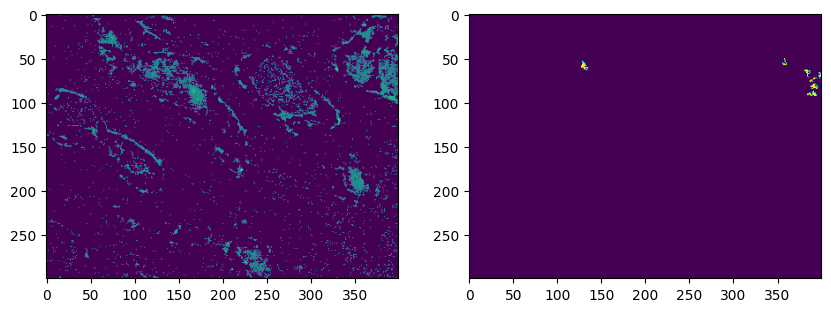

In [43]:
path = "/home/surayuth/her2/Data_Chula/3 Sep HER2 0 case 3/HER2 0 case 3 (1).JPG"
img = read_image(path)
gray = get_dab(img) * (img[:,:,0] > img[:,:,2])
bg_mode = mode(gray.reshape(-1)).mode
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(gray)
axs[1].imshow(prep_mask(~(gray > bg_mode * 2)))

MovieWriter ffmpeg unavailable; using Pillow instead.


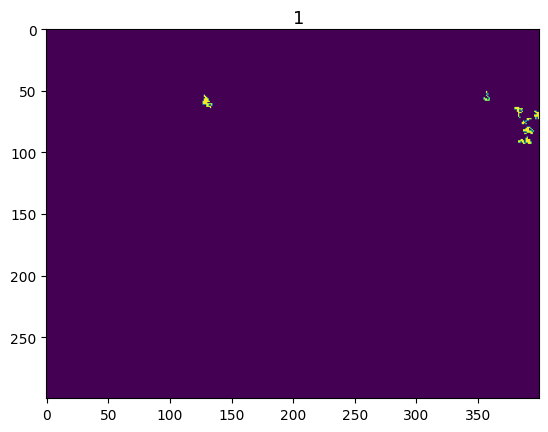

In [44]:
import matplotlib.animation as animation


def data_sequence(i):
    mask = prep_mask(gray < (256 - i))
    return mask

fig, ax = plt.subplots()

frames = []
for i in range(1, 256, 1):
    title = plt.text(200, -5, 256 - i, fontsize=13)
    seq_img = plt.imshow(data_sequence(i), animated=True)
    frames.append([seq_img, title])
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)
ani.save("tmp.gif")

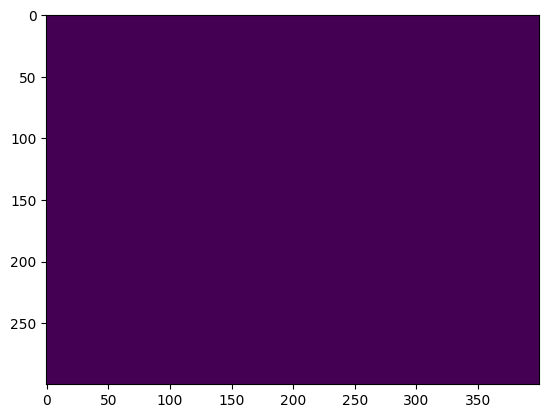

In [31]:
plt.imshow(data_sequence(100))

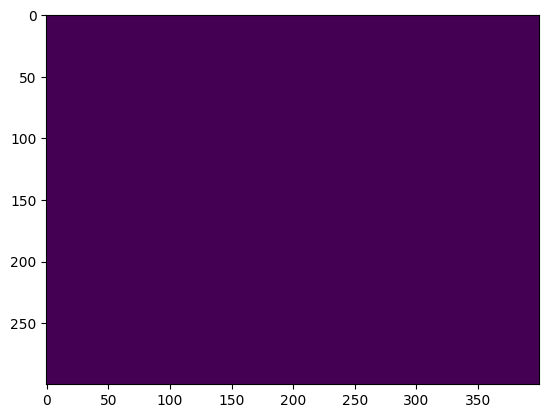

In [32]:
plt.imshow(data_sequence(500))

In [33]:
# timestep = 0
# max_th = 255
# mask = prep_mask(gray < max_th + 1)
# life_dict, labeled_img, max_cur_label = init_hist(mask)
# for th in np.arange(1,max_th)[::-1]:
#     timestep += 1
#     print(timestep)
#     mask = prep_mask(gray < th)
#     life_dict, labeled_img, max_cur_label = update_hist(labeled_img, mask, life_dict, max_cur_label, timestep)

In [34]:
# births = []
# deaths = []
# for k, v in life_dict.items():
#     b = v["birth"]
#     d = v["death"]
#     if d is not None:
#         births.append(b)
#         deaths.append(d)

# births = np.array(births)
# deaths = np.array(deaths)
# lifespan = deaths - births

In [35]:
# plt.scatter(births, deaths, s=1)